# 文本分类的微调

In [1]:
from importlib.metadata import version

pkgs = ["matplotlib",
        "numpy",
        "tiktoken",
        "torch",
        "tensorflow",
        "pandas"
        ]

for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.9.0
numpy version: 1.26.4
tiktoken version: 0.7.0
torch version: 2.3.1
tensorflow version: 2.16.1
pandas version: 2.2.1


![Alt text](../../../img/LLM/ch05/classify_finetune.png)

# 1、不同类别的微调

- 微调语言模型最常见的方法是指令微调和分类微调
- 下面描述的指令微调是下一章的主题

![Alt text](../../../img/LLM/ch05/instruction_finetuning.png)

- 如果你有机器学习的背景，本章的主题是分类微调，这是一个你可能已经熟悉的过程——例如，它类似于训练卷积网络来对手写数字进行分类
- 在分类微调中，我们有特定数量的类标签（例如，“垃圾邮件”和“非垃圾邮件”），模型可以输出这些标签
- 分类微调模型只能预测它在训练中看到的类（例如，“垃圾邮件”或“非垃圾邮件”），而指令微调模型通常可以执行许多任务
- 我们可以把分类微调模型看作是一个非常专业的模型；在实践中，创建一个专门的模型要比创建一个在许多不同任务上表现良好的多面手模型容易得多

![Alt text](../../../img/LLM/ch05/classify_finetuning.png)

# 2、数据集准备

![Alt text](../../../img/LLM/ch05/stage1_classify_finetune.png)

- 本节准备用于分类微调的数据集
- 我们使用由垃圾邮件和非垃圾邮件组成的数据集来微调LLM以对其进行分类
- 首先，我们下载并解压缩数据集

In [2]:
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Downloading the file
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

sms_spam_collection\SMSSpamCollection.tsv already exists. Skipping download and extraction.


- 数据集被保存为一个以制表符分隔的文本文件，我们可以将其加载到Panda DataFrame中

In [3]:
import pandas as pd

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


 - 当我们检查类分布时，我们发现数据中包含“ham”（即“非垃圾邮件”）的频率远高于“垃圾邮件”

In [4]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


- 为了简单起见，而且因为出于教育目的，我们更喜欢小的数据集（这将使更快地微调LLM成为可能），我们对数据集进行了子采样（欠采样），使其包含每个类的747个实例
- （除了采样不足之外，还有其他几种处理类平衡的方法，但它们不在LLM书籍的范围内；您可以在不平衡学习用户指南中找到示例和更多信息）

In [5]:
def create_balanced_dataset(df):
    num_spam = df[df["Label"] == "spam"].shape[0]
    
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)
    
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])
    return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [6]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

- 现在，让我们定义一个函数，将数据集随机划分为训练、验证和测试集

In [7]:
def random_split(df, train_frac, validation_frac):
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)
    
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)
    
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]
    
    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)

train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

# 3、创建数据加载程序

- 请注意，文本消息具有不同的长度；如果我们想在一批中组合多个训练示例，我们必须
    - 将所有消息截断为数据集中或批处理中最短消息的长度
    - 将所有消息填充到数据集中或批处理中最长消息的长度
- 我们选择选项2，并将所有消息填充到数据集中最长的消息中
- 为此，我们使用<|endoftext|>作为填充标记，如第2章所述

![Alt text](../../../img/LLM/ch05/token_padding.png)

In [8]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


- 下面的SpamDataset类标识训练数据集中最长的序列，并将填充标记添加到其他序列以匹配该序列长度

In [9]:
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)
        
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]
        
        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]
            
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]
      
    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )
      
    def __len__(self):
        return len(self.data)
    
    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encode_length = len(encoded_text)
            if encode_length > max_length:
                max_length = encode_length
        return max_length

In [10]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

print(train_dataset.max_length)

120


- 我们还将验证和测试集添加到最长的训练序列中
- 请注意，比最长训练示例更长的验证和测试集样本将通过SpamDataset代码中的encode_text[：self.max_length]截断
- 这种行为是完全可选的，如果我们在验证和测试集的情况下都将max_length设置为None，它也会很好地工作

In [11]:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=None,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=None,
    tokenizer=tokenizer
)

接下来，我们使用数据集实例化数据加载程序，这与前几章中创建数据加载程序类似

![Alt text](../../../img/LLM/ch05/dataloader.png)

In [12]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False
)

- 作为验证步骤，我们对数据加载程序进行迭代，并确保批次中每个包含8个训练示例，其中每个训练示例由120个token组成

In [13]:
print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions:", target_batch.shape)

Train loader:
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions: torch.Size([8])


- 最后，让我们打印每个数据集中的批次总数

In [14]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


# 4、使用预先训练的权重初始化模型

- 在本节中，我们初始化上一章中使用的预训练模型

In [15]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True
}

model_configs = {
    "gpt2-small (124M)": {"embedding_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"embedding_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"embedding_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"embedding_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)

In [52]:
from gpt_download import download_and_load_gpt2
from ch05 import GPTModel, load_weights_into_gpt

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size, "gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe


GPTModel(
  (token_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_features=768, bias=True)
        (W_k): Linear(in_features=768, out_features=768, bias=True)
        (W_v): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ffn): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_q): Linear(in_f

- 为了确保模型被正确加载，让我们仔细检查一下它是否生成了连贯的文本

In [54]:
from ch05 import generate_text_simple, text_to_token_ids, token_ids_to_text

text1 = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


- 在我们将模型作为分类器进行微调之前，让我们看看该模型是否已经可以通过提示对垃圾邮件进行分类

In [55]:
text2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG['context_length']
)

print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


- 正如我们所看到的，该模型在以下说明方面不是很好
- 这是意料之中的事，因为它只是经过了预训练，而不是指令微调（指令微调将在下一章中介绍）

# 5、添加分类head

![Alt text](../../../img/LLM/ch05/classify_head.png)

- 在本节中，我们将修改预训练的LLM，使其为分类微调做好准备
- 让我们先来看看模型体系结构

In [56]:
print(model)

GPTModel(
  (token_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_features=768, bias=True)
        (W_k): Linear(in_features=768, out_features=768, bias=True)
        (W_v): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ffn): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_q): Linear(in_f

- 在上面，我们可以看到我们在第3章中实现的架构
- 目标是替换和微调输出层
- 为了实现这一点，我们首先冻结模型，这意味着我们使所有层都不可训练

In [57]:
for param in model.parameters():
    param.requires_grad = False

- 然后，我们替换输出层（model.out_head），它最初将层输入映射到50257个维度（词汇表的大小）
- 由于我们对二进制分类的模型进行了微调（预测了两个类，“垃圾邮件”和“非垃圾邮件”），我们可以替换输出层，如下所示，默认情况下可以进行训练
- 请注意，我们使用BASE_CONFIG[“emb_dim”]（在“gpt2 small（124M）”模型中等于768）来保持下面的代码更通用

In [58]:
torch.manual_seed(123)

num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["embedding_dim"], out_features=num_classes)

- 从技术上讲，只训练输出层就足够了
- 然而，正如我在微调大型语言模型中发现的那样，实验表明微调附加层可以显著提高性能
- 因此，我们还使最后一个Transformer块和将最后一个Transformer块连接到输出层的最后一个LayerNorm模块可训练

![Alt text](../../../img/LLM/ch05/finetune_architecture.png)

In [59]:
for param in model.transformer_blocks[-1].parameters():
    param.requires_grad = True
    
for param in model.final_norm.parameters():
    param.requires_grad = True

- 我们仍然可以使用与前几章中类似的模型
- 例如，让我们给它一些文本输入

In [60]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


- 与前几章不同的是，它现在有两个输出维度，而不是50257

In [61]:
with torch.no_grad():
    outputs = model(inputs)
    
print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape)

Outputs:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Outputs dimensions: torch.Size([1, 4, 2])


- 如前几章所述，对于每个输入token，都有一个输出向量
- 由于我们向模型提供了一个具有4个输入标记的文本样本，因此输出由上面的4个二维输出向量组成

![Alt text](../../../img/LLM/ch05/finetune_architecture_example.png)

- 在第2章中，我们讨论了注意力机制，它将每个输入token连接到另一个输入token
- 在第2章中，我们还介绍了在类GPT模型中使用的因果注意掩码；该因果掩码使当前token只关注当前和以前的token位置
- 基于这种因果注意机制，第四个（最后一个）令牌包含了所有token中最多的信息，因为它是唯一包含所有其他token信息的token
- 因此，我们对最后一个token特别感兴趣，我们将为垃圾邮件分类任务对其进行微调

In [62]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]])


![Alt text](../../../img/LLM/ch05/casual_attention_mask.png)

# 6、计算分类损失和准确率

![Alt text](../../../img/LLM/ch05/process_loss_accuracy.png)

- 在解释损失计算之前，让我们简要了解一下模型输出是如何转换为类标签的

![Alt text](../../../img/LLM/ch05/output_to_class_label.png)

In [63]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]])


- 与第4章类似，我们通过softmax函数将输出（logits）转换为概率得分，然后通过argmax函数获得最大概率值的索引位置

In [64]:
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)
print("Class label", label.item())

Class label 1


- 请注意，如第4章所述，softmax函数在这里是可选的，因为最大的输出对应于最大的概率分数

In [65]:
logits = outputs[:, -1, :]
label = torch.argmax(logits)
print("Class label", label.item())

Class label 1


- 我们可以将这一概念应用于计算所谓的分类精度，即计算给定数据集中正确预测的百分比
- 为了计算分类精度，我们可以将前面基于argmax的预测代码应用于数据集中的所有示例，并计算正确预测的分数，如下所示：

In [66]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0
    
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)
            
            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]
            predicted_labels = torch.argmax(logits, dim=-1)
            
            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

- 让我们应用该函数来计算不同数据集的分类精度

In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model.to(device)

torch.manual_seed(123)

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


- 正如我们所看到的，预测精度不是很好，因为我们还没有微调模型
- 在我们开始微调（/训练）之前，我们首先必须定义训练期间要优化的损失函数

- 目标是最大限度地提高垃圾邮件分类模型的准确性；然而，分类精度不是一个可微函数

- 因此，相反，我们将交叉熵损失最小化，作为最大化分类精度的代理（您可以在我免费提供的深度学习导论课程的第8讲中了解更多关于此主题的信息）

- 这里的calc_loss_batch函数与第5章中的相同，只是我们只对优化最后一个token模型 (input_batch) [：，-1，：]而不是所有token模型 (input_batch)

In [68]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [69]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [70]:
with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.453
Validation loss: 2.525
Test loss: 2.413


- 在下一节中，我们训练模型以优化损失值，从而提高分类精度

# 7、使用有监督数据微调模型

- 在本节中，我们定义并使用训练函数来提高模型的分类精度
- 下面的train_classifier_sample函数实际上与我们在第5章中用于预训练模型的train_model_simple函数相同
- 唯一的两个区别是我们现在
    - 跟踪看到的训练示例数（examples_seen），而不是看到的示例数
    - 计算每个epoch之后的精度，而不是在每个epoch后打印示例文本

![Alt text](../../../img/LLM/ch05/output_to_class_label.png)

In [71]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [72]:
from tqdm import tqdm

def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    example_seen, global_step = 0, -1
    
    for epoch in tqdm(range(num_epochs)):
        model.train()
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            example_seen += input_batch.shape[0]
            global_step += 1
            
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
                
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)
    return train_losses, val_losses, train_accs, val_accs, example_seen

In [73]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 2
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device, num_epochs=num_epochs, 
    eval_freq=50, eval_iter=5
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Train completed in {execution_time_minutes:.2f} minutes.")

  0%|                                                                               | 0/2 [00:00<?, ?it/s]

Ep 1 (Step 000000): Train loss 2.153, Val loss 2.351
Ep 1 (Step 000050): Train loss 0.617, Val loss 0.624
Ep 1 (Step 000100): Train loss 0.523, Val loss 0.602


 50%|███████████████████████████████████                                   | 1/2 [04:25<04:25, 265.55s/it]

Training accuracy: 70.00% | Validation accuracy: 82.50%
Ep 2 (Step 000150): Train loss 0.561, Val loss 0.465
Ep 2 (Step 000200): Train loss 0.419, Val loss 0.542
Ep 2 (Step 000250): Train loss 0.409, Val loss 0.520


100%|██████████████████████████████████████████████████████████████████████| 2/2 [08:47<00:00, 263.84s/it]

Training accuracy: 82.50% | Validation accuracy: 72.50%
Train completed in 8.87 minutes.


- 我们使用matplotlib来绘制训练集和验证集的loss函数

In [76]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()
    
    ax2 = ax1.twiny()
    ax2.plot(examples_seen, train_values, alpha=0)
    ax2.set_xlabel("Examples seen")
    
    fig.tight_layout()
    plt.show()

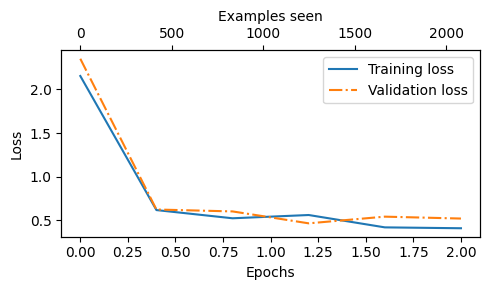

In [77]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

- 上面，基于向下的斜率，我们看到模型学习得很好
- 此外，训练和验证损失非常接近的事实表明，模型不会过度拟合训练数据
- 同样，我们可以在下面绘制准确性

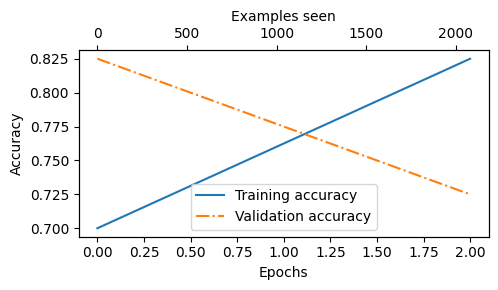

In [78]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

- 根据上面的精度图，我们可以看到，在第4和第5个时期之后，该模型实现了相对较高的训练和验证精度
- 然而，我们必须记住，我们之前在训练函数中指定了eval_iter=5，这意味着我们只估计了训练集和验证集的性能
- 我们可以计算完整数据集的训练、验证和测试集性能，如下所示

In [79]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 84.52%
Validation accuracy: 73.83%
Test accuracy: 83.00%


- 我们可以看到，训练集和验证集的性能实际上是相同的
- 然而，基于略低的测试集性能，我们可以看到，该模型在很小的程度上过度拟合了训练数据，以及用于调整一些超参数的验证数据，如学习率
- 然而，这是正常的，通过增加模型的丢弃率（drop_rate）或优化器设置中的weight_decay，这种差距可能会进一步缩小

# 8、使用LLM作为垃圾邮件分类器

![Alt text](../../../img/LLM/ch05/finetuned_model_to_test.png)

- 最后，让我们使用经过微调的GPT模型
- 下面的classification_preview函数实现了与我们前面实现的SpamDataset类似的数据预处理步骤
- 然后，函数从模型中返回预测的整数类标签，并返回相应的类名

In [80]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    # Prepare inputs to the model
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[1]

    # Truncate sequences if they too long
    input_ids = input_ids[:min(max_length, supported_context_length)]

    # Pad sequences to the longest sequence
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # add batch dimension

    # Model inference
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]  # Logits of the last output token
    predicted_label = torch.argmax(logits, dim=-1).item()

    # Return the classified result
    return "spam" if predicted_label == 1 else "not spam"

In [81]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


In [82]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


In [83]:
torch.save(model.state_dict(), "review_classifier.pth")

In [84]:
model_state_dict = torch.load("review_classifier.pth")
model.load_state_dict(model_state_dict)

<All keys matched successfully>